           signal1   signal2  signal3
t                                    
0.000000  0.000000  1.000000     -0.5
0.000227  0.000227  1.000000     -0.5
0.000909  0.000909  0.999999     -0.5
0.002045  0.002045  0.999996     -0.5
0.003636  0.003636  0.999989     -0.5
...            ...       ...      ...
8.641827 -0.100000  0.000000      0.1
8.730689 -0.100000  0.000000      0.1
8.820005 -0.100000  0.000000      0.1
8.909775 -0.100000  0.000000      0.1
9.000000 -0.100000  0.000000      0.1

[200 rows x 3 columns]


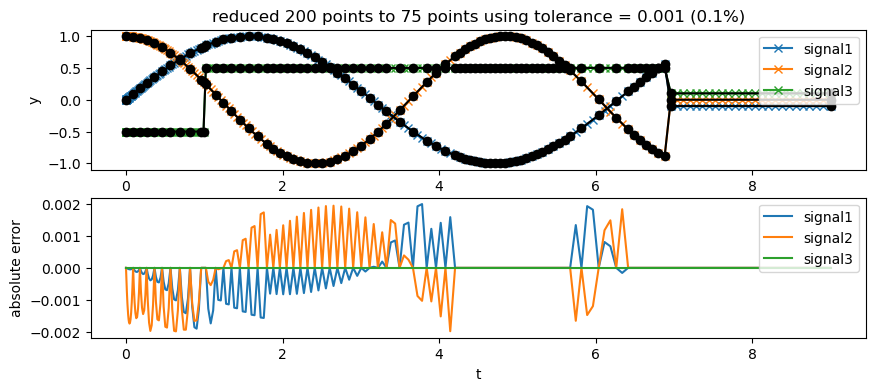

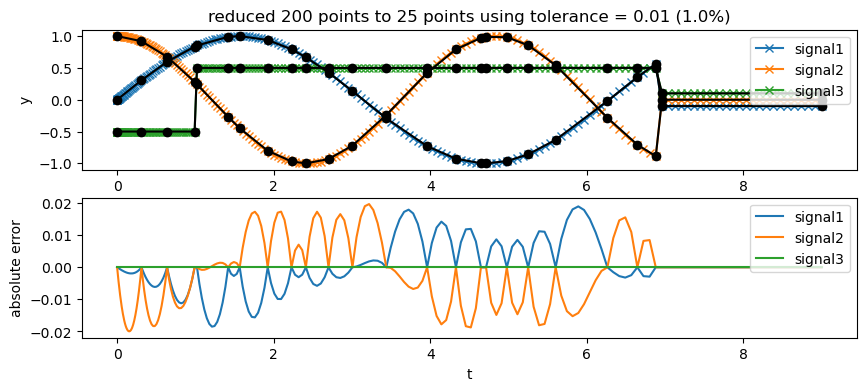

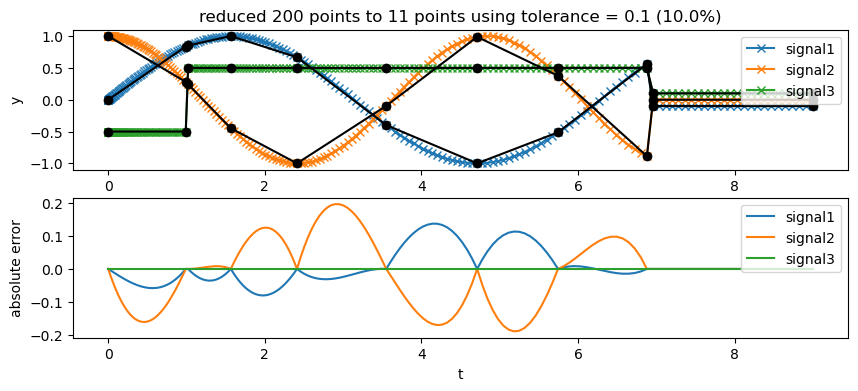

In [238]:
from point_reducer import PointReducer, make_fake_data

df = make_fake_data()
PR =  PointReducer()

for tolerance in [0.001, 0.01, 0.1]:
    df_optimized = PR.reduce_points(df, tolerance)

In [239]:
print(df_optimized)

           signal1   signal2  signal3
t                                    
0.000000  0.000000  1.000000     -0.5
0.989975  0.836012  0.280033     -0.5
1.020202  0.852213  0.242105      0.5
1.565642  0.999987 -0.448010      0.5
2.411075  0.667255 -0.999974      0.5
3.551047 -0.398109 -0.095881      0.5
4.712608 -1.000000  0.987733      0.5
5.745537 -0.512118  0.375359      0.5
6.880735  0.562619 -0.887077      0.5
6.960052 -0.100000  0.000000      0.1
9.000000 -0.100000  0.000000      0.1
